In [193]:
import os
import pandas as pd
import numpy as np
import chinese_calendar as calendar
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from yoda import datetime as datetime_utils
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.font_manager import FontProperties

# 设置全局字体为中文字体
font_path = '/System/Library/Fonts/PingFang.ttc'
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

In [136]:
goods_df1 = pd.read_excel('./data/货品-1.xlsx')
goods_df2 = pd.read_excel('./data/货品-2.xlsx')
goods_df = pd.concat([goods_df1, goods_df2])
columns = ['货品编号', '货品名称', '分类']
goods_df = goods_df[columns].rename(columns={'分类': '分类名称'})
goods_df

,货品编号,货品名称,分类名称
0,Q26,【趁夜出逃】黑色辅助皮革脚手铐另类情趣男女调教成人情趣激情捆绑束缚器具Q26,SM套装
1,N17,亏本热卖·Galaku 迷你觅蕾情趣尖圆共振遥控双跳蛋高频刺激静音强震性趣用品N17,跳蛋
2,N23,安太医 外用延时巾3片装 （牛油盒）男士延时喷剂延迟持久房事成人情趣用品 N23,延时液
3,N27,【亏本热卖】兔女面具捆绑刑具调情面具夫妻激情用品情侣面罩多件刑具男女惩罚床上性趣用品N27,SM套装
4,E89,【蕾云轻奢·蜜桃臀】谜姬小巧美臀精致诱惑双通阴臀倒模逼真涂色男用成人用品E89,阴臀倒模
...,...,...,...
195,208,『激情放纵』深v网纱诱惑腰间系带火辣性感比基尼连体衣套装情趣内衣成人白G025 208,情趣套装
196,209,【紫色の蝴蝶结】日系甜蜜少女内裤纯欲镂空露臀蕾丝性感低腰三角裤紫色Z3041成人情趣209,情趣内裤
197,210,『今夜跟你走』蕾丝性感新娘套装吊带婚纱蓬蓬裙透明情趣内衣诱惑超短裙-黑 G607 210,情趣套装
198,212,【海蓝T裤】pink日系甜蜜少女内裤纯欲镂空露臀蕾丝性感诱惑蓝色1条Z3041成人212,情趣内裤


In [137]:
cate_df = pd.read_excel('./data/货品分类.xlsx', engine='openpyxl')
cate_df = cate_df[['分类编码', '分类名称', '上级分类编码', '上级分类名称']]
cate_df['上级分类编码'] = cate_df['上级分类编码'].fillna(0).astype(int)
cate_df

/Users/qhkjit/.virtualenvs/venv-pql/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,分类编码,分类名称,上级分类编码,上级分类名称
0,1,店铺公告,0,NaN
1,10,成人用品配件,0,NaN
2,11,信息公告,1,店铺公告
3,12,SM套装,6,情趣玩具
4,13,跳蛋,2,女用器具
5,14,充气/实体娃娃,9,男用器具
6,15,吸舔器,2,女用器具
7,16,缩阴球,2,女用器具
8,17,震动棒,2,女用器具
9,18,吊袜带,5,情趣内衣


In [138]:
goods_cate_df = goods_df.merge(cate_df, how='left', on='分类名称')
goods_cate_df.sort_values(by=['上级分类编码', '分类编码', '货品编号'], inplace=True)
goods_cate_df['货品ID'] = goods_cate_df.index
goods_cate_df

,货品编号,货品名称,分类名称,分类编码,上级分类编码,上级分类名称,货品ID
1004,1212,测试,店铺公告,1.0,0.0,NaN,1004
88,265,网红婚纱冰丝性感蕾丝黑色手套长款薄防晒袖套透气无痕制服内衣配饰 1副265,成人用品配件,10.0,0.0,NaN,88
83,266,〖白天鹅〗网红婚纱冰丝性感蕾丝白色手套长款薄防晒袖套透气无痕制服内衣配饰 1副266,成人用品配件,10.0,0.0,NaN,83
342,A51,【摇玲变装】网红蕾丝小铃铛项圈女颈带脖子情趣猫挂脖女仆平脖环项链成人用品A51,成人用品配件,10.0,0.0,NaN,342
403,B43,【PD快充套装】适用苹果iPhone8-13快充套装3C认证苹果20W快充头数据线 B43,成人用品配件,10.0,0.0,NaN,403
...,...,...,...,...,...,...,...
882,L23,【琉璃黄瓜】女用自慰器后庭G店摩擦高潮颗粒水晶玻璃自慰棒刺激肛塞情趣成人用品L23,后庭按摩器,38.0,9.0,男用器具,882
890,M05,快乐水手 后庭肛塞硅胶扩肛夫妻房事用品拉珠成人女性肛门调情趣性玩具开发菊花1个 M05,后庭按摩器,38.0,9.0,男用器具,890
108,Q12,久兴毒龙钻毒龙塞系列无线遥控电动前列腺按摩棒锁阳肛塞后庭理疗震动器 Q12,后庭按摩器,38.0,9.0,男用器具,108
1001,004,【绝绝紫】薄款情趣丝袜免脱直入开档连裤袜超薄手撕网红款彩色无痕夜场成人情趣用品紫色004紫色开档,NaN,NaN,NaN,NaN,1001


In [139]:
platform_goods_df = pd.read_excel('./data/平台商品列表.xlsx')
columns = ['货品编号（系统）', '商品价格（网店）']
platform_goods_df = platform_goods_df[columns].rename(
    columns={'货品编号（系统）': '货品编号', '商品价格（网店）': '商品价格'})
platform_goods_df = platform_goods_df.dropna(subset=['货品编号'])
platform_goods_df

,货品编号,商品价格
0,T31,18890.0
1,T25,4880.0
2,T30,3998.0
3,T23,3988.0
4,T21,3988.0
...,...,...
1109,gggmbss,0.0
1110,ggzpwy,0.0
1111,gghwys,0.0
1112,ggxkxd-4,0.0


In [140]:
goods_df = goods_cate_df.merge(platform_goods_df, on='货品编号', how='left')
# 有 92个商品不在平台商品中
# print(goods_df[goods_df['商品价格'].isna()].index.size)
avg_price = goods_df['商品价格'].mean()
median_price = goods_df['商品价格'].median()
mode_price = goods_df['商品价格'].mode()
price = (avg_price + median_price) / 2
goods_df['商品价格'] = goods_df['商品价格'].fillna(price)
goods_df['分类编码'] = goods_df['分类编码'].fillna(-1).astype(int)
goods_df['上级分类编码'] = goods_df['上级分类编码'].fillna(-1).astype(int)
goods_df

,货品编号,货品名称,分类名称,分类编码,上级分类编码,上级分类名称,货品ID,商品价格
0,1212,测试,店铺公告,1,0,NaN,1004,113.920436
1,265,网红婚纱冰丝性感蕾丝黑色手套长款薄防晒袖套透气无痕制服内衣配饰 1副265,成人用品配件,10,0,NaN,88,48.000000
2,266,〖白天鹅〗网红婚纱冰丝性感蕾丝白色手套长款薄防晒袖套透气无痕制服内衣配饰 1副266,成人用品配件,10,0,NaN,83,59.000000
3,A51,【摇玲变装】网红蕾丝小铃铛项圈女颈带脖子情趣猫挂脖女仆平脖环项链成人用品A51,成人用品配件,10,0,NaN,342,25.000000
4,B43,【PD快充套装】适用苹果iPhone8-13快充套装3C认证苹果20W快充头数据线 B43,成人用品配件,10,0,NaN,403,69.900000
...,...,...,...,...,...,...,...,...
1200,L23,【琉璃黄瓜】女用自慰器后庭G店摩擦高潮颗粒水晶玻璃自慰棒刺激肛塞情趣成人用品L23,后庭按摩器,38,9,男用器具,882,88.000000
1201,M05,快乐水手 后庭肛塞硅胶扩肛夫妻房事用品拉珠成人女性肛门调情趣性玩具开发菊花1个 M05,后庭按摩器,38,9,男用器具,890,30.000000
1202,Q12,久兴毒龙钻毒龙塞系列无线遥控电动前列腺按摩棒锁阳肛塞后庭理疗震动器 Q12,后庭按摩器,38,9,男用器具,108,113.920436
1203,004,【绝绝紫】薄款情趣丝袜免脱直入开档连裤袜超薄手撕网红款彩色无痕夜场成人情趣用品紫色004紫色开档,NaN,-1,-1,NaN,1001,23.000000


In [141]:
order_detail_df = pd.read_excel('./data/销售单查询.xlsx', sheet_name='sheet1')
order_detail_df = order_detail_df[['订单编号', '货品编号', '数量']]
order_detail_df

,订单编号,货品编号,数量
0,JY202310080138,B31,1
1,JY202310080138,S19,1
2,JY202310080138,M38,1
3,JY202310080137,D05,1
4,JY202310080137,D66,1
...,...,...,...
22160,JY202309080003,262,1
22161,JY202309080003,255,1
22162,JY202309080002,B19,1
22163,JY202309080002,B17,1


In [142]:
order_df = pd.read_excel('./data/销售单查询.xlsx', sheet_name='sheet0', parse_dates=['付款时间', '发货时间'])
# 对于没有付款时间的订单，用发货时间代替
order_df['付款时间'].fillna(order_df['发货时间'], inplace=True)
order_df = order_df[['订单编号', '订单状态', '付款时间', '发货仓库']]
order_df

,订单编号,订单状态,付款时间,发货仓库
0,JY202310080138,待发货-已递交,2023-10-08 17:59:05,清河
1,JY202310080137,待发货-已递交,2023-10-08 17:48:20,朝阳门
2,JY202310080136,待发货-已递交,2023-10-08 17:42:25,百子湾
3,JY202310080135,待发货-已递交,2023-10-08 17:37:45,回龙观
4,JY202310080134,待发货-已递交,2023-10-08 17:35:42,朝阳门
...,...,...,...,...
6483,JY202309080005,发货在途,2023-09-08 00:29:27,朝阳门
6484,JY202309080004,已完成,2023-09-08 00:28:51,百子湾
6485,JY202309080003,已取消,2023-09-08 00:27:09,菜户营
6486,JY202309080002,已完成,2023-09-08 00:25:22,方庄


In [143]:
df = order_detail_df.merge(order_df, on='订单编号', how='left')
df = df[df['订单状态'].isin(['发货在途', '已完成'])]
df['日期'] = df['付款时间'].dt.date.apply(lambda x: x.strftime('%Y%m%d')).astype(int)
df

,订单编号,货品编号,数量,订单状态,付款时间,发货仓库,日期
105,JY202310080105,B10,1,已完成,2023-10-08 16:38:25,清河,20231008
106,JY202310080105,S11,1,已完成,2023-10-08 16:38:25,清河,20231008
129,JY202310080096,A06,1,已完成,2023-10-08 16:04:41,百子湾,20231008
130,JY202310080096,302,1,已完成,2023-10-08 16:04:41,百子湾,20231008
131,JY202310080096,S06,1,已完成,2023-10-08 16:04:41,百子湾,20231008
...,...,...,...,...,...,...,...
22149,JY202309080005,D57,1,发货在途,2023-09-08 00:29:27,朝阳门,20230908
22150,JY202309080004,A26,1,已完成,2023-09-08 00:28:51,百子湾,20230908
22162,JY202309080002,B19,1,已完成,2023-09-08 00:25:22,方庄,20230908
22163,JY202309080002,B17,1,已完成,2023-09-08 00:25:22,方庄,20230908


In [144]:
# 按日期门店货品分组，统计每天销量
store_day_goods_df = df.groupby(['日期', '发货仓库', '货品编号'])['数量'].sum().reset_index()
store_day_goods_df

,日期,发货仓库,货品编号,数量
0,20230908,东直门,001,1
1,20230908,东直门,002,2
2,20230908,东直门,003,1
3,20230908,东直门,005,1
4,20230908,东直门,008,1
...,...,...,...,...
14247,20231008,菜户营,S11,1
14248,20231008,菜户营,S19,1
14249,20231008,菜户营,gggmbss,2
14250,20231008,菜户营,gghwys,2


In [145]:
def is_holiday(date):
    """
    判断是否是节假日
    """
    return calendar.is_holiday(date)


# 合并货品相关属性
store_df = store_day_goods_df.merge(goods_df, on='货品编号', how='left')

# 添加日期相关属性
store_df['datetime'] = store_df['日期'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
store_df['星期'] = store_df['datetime'].dt.weekday + 1
store_df['是否节假日'] = store_df['datetime'].apply(is_holiday).astype(int)
store_df = store_df.sort_values(by=['日期'])
store_df

,日期,发货仓库,货品编号,数量,货品名称,分类名称,分类编码,上级分类编码,上级分类名称,货品ID,商品价格,datetime,星期,是否节假日
0,20230908,东直门,001,1,『纯欲奶白』女士性感免脱两面开档丝袜连体手撕连裤袜情趣打底袜子成人用品3003白色001,情趣丝袜,27,5,情趣内衣,1005,26.000000,2023-09-08,5,0
451,20230908,百子湾,E78,1,【根本停不下来】COBILY劲能延时喷剂3ml男用久站喷雾控时喷剂外用成人用品E78,延时液,19,8,润滑助情,636,28.000000,2023-09-08,5,0
452,20230908,百子湾,E79,2,【麦艾斯】延时避孕套2只装52mm纤薄润滑劲久男用成人用品E79,避孕套/安全套,25,3,安全避孕,637,16.000000,2023-09-08,5,0
453,20230908,百子湾,E82,2,【无线遥控+十频强震】贝丝远程无线遥控外出穿戴跳蛋震动棒女性自慰器成人情趣用品E82,跳蛋,13,2,女用器具,640,74.000000,2023-09-08,5,0
454,20230908,百子湾,E86,1,【双层到头+轻松除毛】拉美拉女用腋毛手动剃毛刀刮毛刀（送2刀头）成人情趣用品E86,情趣用品清洁(新),40,8,润滑助情,644,23.000000,2023-09-08,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14180,20231008,方庄,A44,1,【舌舔+外撩+充电+谜姬】迷情女用震动棒电动变频双震AV棒女性高潮自慰振动按摩器成人A44,震动棒,17,2,女用器具,335,83.000000,2023-10-08,7,0
14179,20231008,方庄,A07,1,『撩拨春心』性感蕾丝挂脖漏背开档蕾丝透视弹力连体连身情趣内衣成人用品黑Y8607 A07,情趣丝袜,27,5,情趣内衣,298,20.000000,2023-10-08,7,0
14178,20231008,方庄,A06,1,『迷情透视』性感免脱两面开档连体手撕连裤袜情趣打底成人用品情趣内衣黑3003 A06,情趣丝袜,27,5,情趣内衣,297,15.000000,2023-10-08,7,0
14191,20231008,方庄,ggjsps,1,【急速配送】急速送达，风雨无阻！,信息公告,11,1,店铺公告,42,113.920436,2023-10-08,7,0


In [245]:
# 按门店预测每个货品的销量
store_name = '百子湾'
df = store_df[store_df['发货仓库'] == store_name]
df

,日期,发货仓库,货品编号,数量,货品名称,分类名称,分类编码,上级分类编码,上级分类名称,货品ID,商品价格,datetime,星期,是否节假日
451,20230908,百子湾,E78,1,【根本停不下来】COBILY劲能延时喷剂3ml男用久站喷雾控时喷剂外用成人用品E78,延时液,19,8,润滑助情,636,28.0,2023-09-08,5,0
452,20230908,百子湾,E79,2,【麦艾斯】延时避孕套2只装52mm纤薄润滑劲久男用成人用品E79,避孕套/安全套,25,3,安全避孕,637,16.0,2023-09-08,5,0
453,20230908,百子湾,E82,2,【无线遥控+十频强震】贝丝远程无线遥控外出穿戴跳蛋震动棒女性自慰器成人情趣用品E82,跳蛋,13,2,女用器具,640,74.0,2023-09-08,5,0
454,20230908,百子湾,E86,1,【双层到头+轻松除毛】拉美拉女用腋毛手动剃毛刀刮毛刀（送2刀头）成人情趣用品E86,情趣用品清洁(新),40,8,润滑助情,644,23.0,2023-09-08,5,0
455,20230908,百子湾,E90,1,【巅峰嗨点av棒】N多花样搅拌性爱刺激高潮装兴奋女性调情秒潮成人配2节7号电池E90,震动棒,17,2,女用器具,647,17.0,2023-09-08,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14209,20231008,百子湾,174,1,【无痕冰丝】女式无痕纯棉丁字裤性感冰丝一片式隐形内裤三角裤丁字裤肤色Z1340 174,情趣内裤,28,5,情趣内衣,1165,18.0,2023-10-08,7,0
14240,20231008,百子湾,S15,1,『哥哥不要撕』超薄情趣黑丝手撕袜丝袜打底连裤袜情趣丝袜成人用品情趣内衣 S15,情趣丝袜,27,5,情趣内衣,961,12.0,2023-10-08,7,0
14208,20231008,百子湾,154,1,【御姐ins风】欧美网红烫钻四面镂空女士连体网袜诱惑连裤渔打底网袜子黑色成人W28 154,情趣丝袜,27,5,情趣内衣,1145,28.0,2023-10-08,7,0
14206,20231008,百子湾,024,1,『夜店公主』亮丝夜店秘书性感老师+长筒黑丝袜诱惑情趣内衣配10号丝袜C1033 [024],情趣套装,29,5,情趣内衣,1027,36.0,2023-10-08,7,0


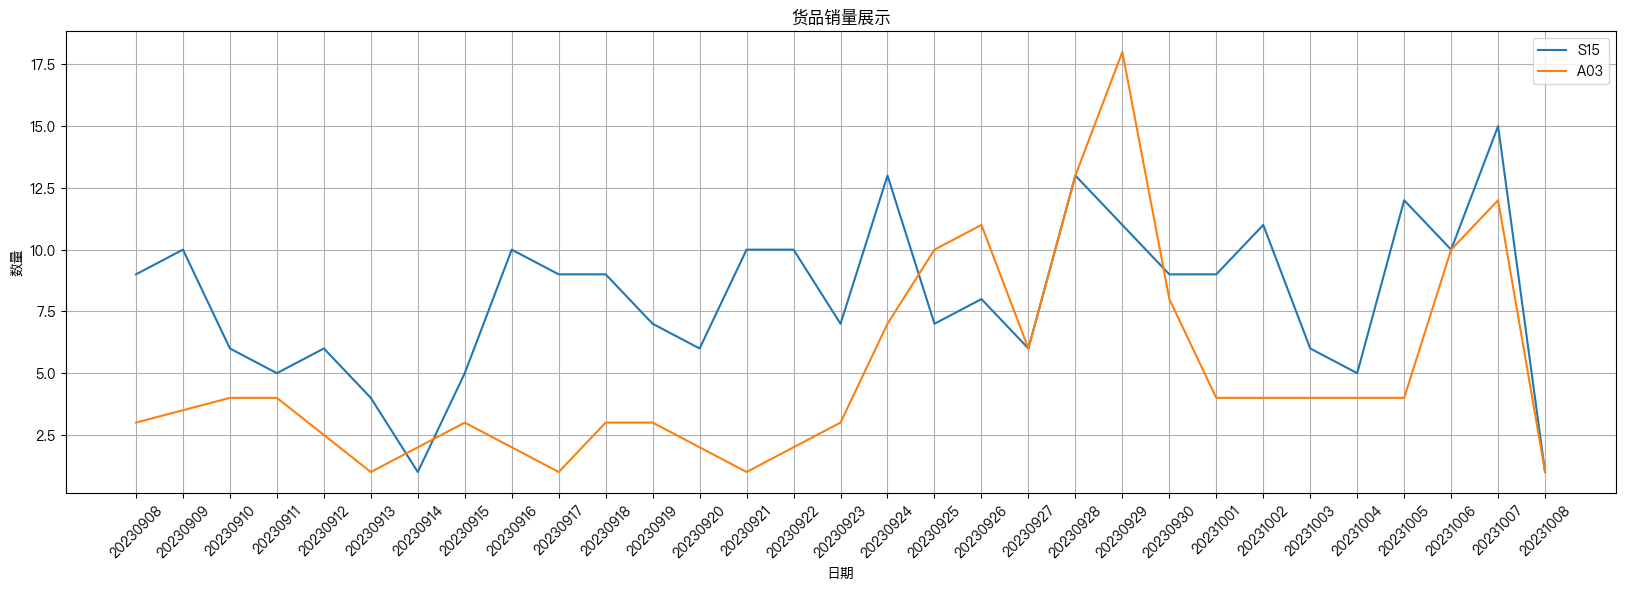

<Figure size 640x480 with 0 Axes>

In [263]:
# 绘制销量前5货品的日纬度销量曲线
fig, ax = plt.subplots(figsize=(20, 6))
sell_goods_df = df.groupby('货品编号')['数量'].sum().sort_values(ascending=False).reset_index().rename(columns={'数量': '总销量'})
sell_goods_df['日平均销量'] = sell_goods_df['总销量'] / df['日期'].nunique()
for goods_id in sell_goods_df['货品编号'][0:2]:
    select_goods_df = df[df['货品编号'] == goods_id]
    select_goods_df = select_goods_df.sort_values(by=['日期'])
    ax.plot(select_goods_df['日期'].astype(str), select_goods_df['数量'], label=goods_id)

ax.legend()
ax.set_title('货品销量展示')
ax.set_xlabel('日期')
ax.set_ylabel('数量')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.tight_layout()

In [179]:
# 统计门店历史无销量的货品
sell_goods_ids = df['货品编号'].unique()
unsold_goods_df = goods_df[~goods_df['货品编号'].isin(sell_goods_ids)]
unsold_goods_df

,货品编号,货品名称,分类名称,分类编码,上级分类编码,上级分类名称,货品ID,商品价格
0,1212,测试,店铺公告,1,0,NaN,1004,113.920436
1,265,网红婚纱冰丝性感蕾丝黑色手套长款薄防晒袖套透气无痕制服内衣配饰 1副265,成人用品配件,10,0,NaN,88,48.000000
2,266,〖白天鹅〗网红婚纱冰丝性感蕾丝白色手套长款薄防晒袖套透气无痕制服内衣配饰 1副266,成人用品配件,10,0,NaN,83,59.000000
4,B43,【PD快充套装】适用苹果iPhone8-13快充套装3C认证苹果20W快充头数据线 B43,成人用品配件,10,0,NaN,403,69.900000
11,G30,【飞机杯专用清洗棒】名器欢色冲洗棒阴道冲洗器实体娃娃清洗棒成人情趣用品G30,成人用品配件,10,0,NaN,707,47.000000
...,...,...,...,...,...,...,...,...
1196,L14,欧亚思 R2猛士电击刺激后庭高潮震动棒按摩器前列腺 L14,后庭按摩器,38,9,男用器具,873,415.000000
1197,L18,xGALAKU手机异地操控智能前列腺肛门震动按摩器男用L型后庭刺激情趣自慰成人用具 L18,后庭按摩器,38,9,男用器具,877,313.000000
1199,L22,【形影相随】水晶玻璃阳具加温棒女性用大颗粒自慰器具后庭肛门塞成人用品 L22,后庭按摩器,38,9,男用器具,881,78.000000
1202,Q12,久兴毒龙钻毒龙塞系列无线遥控电动前列腺按摩棒锁阳肛塞后庭理疗震动器 Q12,后庭按摩器,38,9,男用器具,108,113.920436


In [260]:
# 选取需要的特征列，并做数据归一化处理
feature_columns = ['是否节假日', '货品ID', '分类编码', '商品价格']
feature_size = len(feature_columns)
predict_columns = ['数量']
predict_size = len(predict_columns)

# 2.1、训练特征集
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(df[feature_columns])
# 80%训练集，20%验证集
train_size = int(len(scaled_x) * 0.8)
# train_x = np.reshape(scaled_x, (scaled_x.shape[0], 1, scaled_x.shape[1]))
train_x = scaled_x[:train_size]
test_x = scaled_x[train_size:]
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

# 2.2、训练结果集
order_scaler = StandardScaler()
scaled_y = order_scaler.fit_transform(df[predict_columns])
train_y = scaled_y[:train_size]
test_y = scaled_y[train_size:]
train_y = np.reshape(train_y, (train_y.shape[0], 1, train_y.shape[1]))
test_y = np.reshape(test_y, (test_y.shape[0], 1, test_y.shape[1]))

In [261]:
# 3、构建模型
model_name = f'store-{store_name}-goods-predict-model.h5'
# 3.1 定义模型
model = Sequential()
model.add(LSTM(10, return_sequences=True, input_shape=(1, feature_size)))
model.add(LSTM(10))
model.add(Dropout(0.1))
# model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(predict_size))

# 3.2 编译模型
model.compile(loss='mse', optimizer='nadam')

# 3.3 加载模型权重
model_path = './model'
if not os.path.exists(model_path):
    os.makedirs(model_path, 0o755)
file_path = os.path.join(model_path, model_name)
if os.path.exists(file_path):
    model.load_weights(file_path)

In [262]:
# 4、训练模型
epochs = 100
batch_size = 10
verbose = 1
log_dir = './logs/fit/' + datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,
          validation_data=(test_x, test_y), callbacks=[tensorboard_callback])
# model.save(file_path)

Epoch 1/100
264/264 [==============================] - 9s 8ms/step - loss: 0.9790 - val_loss: 1.0865
Epoch 2/100
264/264 [==============================] - 1s 4ms/step - loss: 0.9777 - val_loss: 1.0849
Epoch 3/100
264/264 [==============================] - 1s 4ms/step - loss: 0.9756 - val_loss: 1.0852
Epoch 4/100
264/264 [==============================] - 1s 4ms/step - loss: 0.9718 - val_loss: 1.0794
Epoch 5/100
264/264 [==============================] - 1s 4ms/step - loss: 0.9652 - val_loss: 1.0757
Epoch 6/100
264/264 [==============================] - 1s 4ms/step - loss: 0.9563 - val_loss: 1.0696
Epoch 7/100
264/264 [==============================] - 1s 4ms/step - loss: 0.9481 - val_loss: 1.0658
Epoch 8/100
264/264 [==============================] - 1s 4ms/step - loss: 0.9425 - val_loss: 1.0649
Epoch 9/100
264/264 [==============================] - 1s 4ms/step - loss: 0.9374 - val_loss: 1.0574
Epoch 10/100
264/264 [==============================] - 1s 4ms/step - loss: 0.9333 - val_lo

In [251]:
# 5、预测结果
tomorrow = datetime_utils.prcnow().shift(days=-2)
# tomorrow = datetime_utils.prcnow().shift(days=1)
predict_begin_day = int(tomorrow.format('YYYYMMDD'))
# 默认预测未来7天的订单
predict_delta_days = 1
predict_dfs = []
for i in range(predict_delta_days):
    day = int(tomorrow.shift(days=i).format('YYYYMMDD'))
    predict_df = goods_df[goods_df['货品编号'].isin(sell_goods_ids)][['货品ID', '分类编码', '上级分类编码', '商品价格']]
    predict_df = predict_df.assign(日期=day)
    # predict_df['日期'] = day
    predict_dfs.append(predict_df)
predict_df = pd.concat(predict_dfs)

predict_df['datetime'] = predict_df['日期'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
predict_df['星期'] = predict_df['datetime'].dt.weekday + 1
predict_df['是否节假日'] = predict_df['datetime'].apply(is_holiday).astype(int)
del predict_df['datetime']
predict_df = predict_df.sort_values(by=['日期'])
predict_data = scaler.fit_transform(predict_df[feature_columns])
test_x = np.reshape(predict_data, (predict_data.shape[0], 1, predict_data.shape[1]))
predict_result = model.predict(test_x)
predict_result

array([[ 4.74812612e-02],
       [-1.30711555e-01],
       [-1.30567074e-01],
       [-1.43592507e-01],
       [-1.43452585e-01],
       [-1.16213836e-01],
       [-2.03745693e-01],
       [-1.29406959e-01],
       [-1.88420057e-01],
       [-1.42062217e-01],
       [-1.55262113e-01],
       [-2.66867459e-01],
       [-2.91036874e-01],
       [ 2.25170106e-02],
       [ 3.91187966e-02],
       [-2.95162231e-01],
       [ 1.50131956e-02],
       [-5.00831231e-02],
       [ 1.38737291e-01],
       [-1.68322176e-01],
       [-1.42202169e-01],
       [-1.53427750e-01],
       [-1.28874242e-01],
       [-4.22875956e-02],
       [-2.96167880e-02],
       [-3.51426825e-02],
       [-9.25883949e-02],
       [-5.91791496e-02],
       [-1.05515964e-01],
       [-1.28657937e-01],
       [-1.17128216e-01],
       [-2.64147371e-01],
       [ 4.21849489e-02],
       [-7.77783766e-02],
       [ 1.35428175e-01],
       [ 2.77892221e-02],
       [ 4.35062051e-02],
       [-1.74408197e-01],
       [-3.0

In [257]:
# 6、预测结果反归一化
predict_order = order_scaler.inverse_transform(predict_result)
predict_df.loc[:, ['预测销量']] = predict_order
result_df = predict_df.merge(goods_df[['货品ID', '货品编号']], on='货品ID', how='left')
result_df = result_df.merge(df[['日期', '货品ID', '数量']], on=['日期', '货品ID'], how='left')
result_df = result_df.merge(sell_goods_df[['货品编号', '总销量', '日平均销量']], on='货品编号', how='left')
result_df['总销量'].fillna(0, inplace=True)
result_df['日平均销量'].fillna(0, inplace=True)
result_df['数量'].fillna(0, inplace=True)
result_df

,货品ID,分类编码,上级分类编码,商品价格,日期,星期,是否节假日,预测销量,货品编号,数量,总销量,日平均销量
0,342,10,0,25.0,20231008,7,0,1.687359,A51,0.0,4,0.129032
1,228,31,5,44.0,20231008,7,0,1.428985,310,0.0,3,0.096774
2,229,31,5,44.0,20231008,7,0,1.429194,311,0.0,9,0.290323
3,232,31,5,50.0,20231008,7,0,1.410308,314,0.0,3,0.096774
4,233,31,5,50.0,20231008,7,0,1.410511,315,0.0,2,0.064516
...,...,...,...,...,...,...,...,...,...,...,...,...
720,1016,27,5,28.0,20231008,7,0,1.760459,013,0.0,16,0.516129
721,1017,27,5,28.0,20231008,7,0,1.760846,014,0.0,13,0.419355
722,1036,27,5,35.0,20231008,7,0,1.737837,033,0.0,25,0.806452
723,1108,27,5,45.0,20231008,7,0,1.721945,112,0.0,11,0.354839
